# TP : Proximal coordinate descent method on regression models

#### Authors: R. Gower, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 16 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Léa"
ln1 = "Bresson"
fn2 = "Eya"
ln2 = "Kalboussi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_bresson_léa_and_kalboussi_eya.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

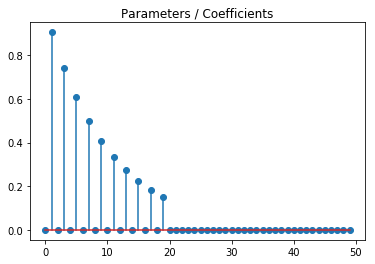

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}^n_+$, where $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### Computing Lasso Penalization and Indicator function:

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return np.sign(x) * np.maximum(np.abs(x) - s * t, np.zeros(x.size))
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s * np.linalg.norm(x, ord=1)

def prox_Indic(x,s):
    """Proximal operator for the Indicator function at x with strength t"""
    """This is equivalent to finding the projection of y on R+"""
    result=x
    result[np.where(x<0)]=0
    return  result
    
def Indic(x,s):
    """Value of the Indicator function at x with strength t"""
    if (min(x)<0):
        result=np.inf
    else:
        result=0   
    return result

## Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions

We want to minimize, with respect to x:
$$
F(x)=  \frac{1}{2} \|b - Ax\|^2 + g(x) = f(x) + \sum_{i=1}^{n} g_i(x^{(i)}) 
$$
with
$g(x) = s \|x\|_1$ (lasso penalization) or $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$ (indicator function of $\mathbb{R}^n_+$).

The function f is convex and differentiable. Moreover, g is convex and separable. Therefore, we have a composite convex minimization problem : if $f(x)$ is minimized along each coordinate axis, the minimizer is global. In this context, the proximal coordinate descend method can be applied.

Note : 
- for the lasso penalization, $g_i(x^{(i)}) = s\ |x^{(i)}|$
- for the indicator function, $g_i(x^{(i)})= i_{x \in \mathbb{R}_+}(\cdot) $ 

## Computing the gradient :

For the Lasso penalization, we can use the results of Lab1. 
$$
\nabla^2 f(x)=A^T\ A
$$
Consequently: 
$$
\nabla^2_i f(x)= A^T_i \ A_i
$$
We can then consider the step for the coordinate descent as follows:
$$
Step_i=\frac{1}{L_i}=\frac{1}{||A_i||^2}
$$


# Proximal coordinate descent : 

In [7]:
def prox_indic_Coord(x,s):
    return max(x,0)

In [ ]:
def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    n_samples, n_features = A.shape
    
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)
    
    if verbose:
        print("Launching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    L=np.sum(A*A,axis=0)
    Residual=np.dot(A,x)-b
   
    for k in range(n_iter + 1):
        
        i=k % n_features
        grad_f= np.dot(A[:,i].T,Residual)
        step=1/L[i]
        x_new[i]=prox_g(x[i]-step*grad_f,s)
            
        Residual+=(x_new[i]-x[i])*A[:,i]
        x=x_new.copy()
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors


# Evaluate qualitatively the convergence when varying the conditioning of the problem

From our point of view, the conditioning of the problem is related to the penalization (regularization parameter) and the "data structure" (correlation, number of samples and features). Therefore, we will study : 

- i) the effect of the penalization function,

- ii) the effect of the regularization parameter,

- iii) the effect of the correlation of the features,

- iv) the simultaneous effect of the regularization parameter and correlation of the features,

- v) the effect of the number of samples.

# i) Effect of the penalization function
### Data

In [9]:
A,b=simu_linreg(coefs)
x0=np.random.randn(n_features)
s=0.01

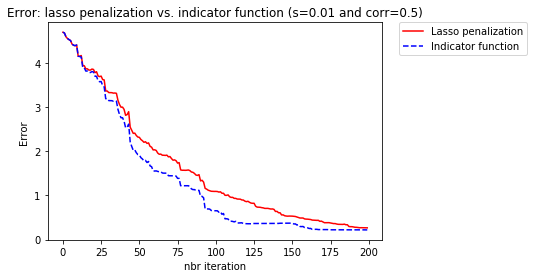

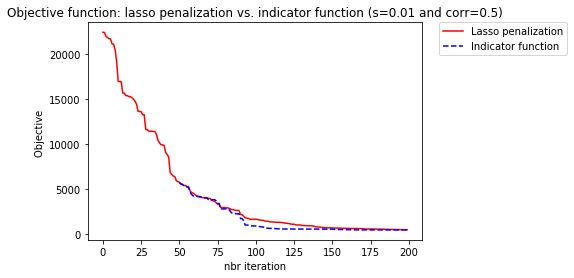

In [10]:
x,objectives,errors=cd_linreg(x0,A,b,lasso,prox_lasso,s=s,n_iter=500,x_true=coefs,verbose=False)
x2,objectives2,errors2=cd_linreg(x0,A,b,Indic,prox_indic_Coord,s=s,n_iter=500,x_true=coefs,verbose=False)

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(errors[:200],"r",label = "Lasso penalization")
ax.plot(errors2[:200],"b--",label = "Indicator function") 
ax.set_xlabel("nbr iteration")
ax.set_ylabel("Error ")
#ax.set_yscale("log")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Error: lasso penalization vs. indicator function (s=0.01 and corr=0.5)")
plt.show()

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(objectives[:200],"r",label = "Lasso penalization")
ax.plot(objectives2[:200],"b--",label = "Indicator function") 
ax.set_xlabel("nbr iteration")
ax.set_ylabel("Objective ")
#ax.set_yscale("log")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Objective function: lasso penalization vs. indicator function (s=0.01 and corr=0.5)")
plt.show()

### Comment :

Using the "default" parameter values (i.e. the ones given in TP1: s=0.01, corr=0.5, n_samples=1000), the algorithm with the indicator function converges faster than the algorithm with the lasso penalization.
Varying the parameter values may change this observation.

We can see that for the 50 first iterations, the objective is infinity, which makes sense since x0 is a random vector. Some coordinates of x0 might be negative, consequently g(x) = infinity until all the coordinates of x are processed.

# ii) Effect of the level of penalization
## Lasso Penalization
### Data

In [11]:
A,b=simu_linreg(coefs)
x0=np.random.randn(n_features)
s=[0.001,0.1,0.3,1,10,100]

In [12]:
list_errors=[]
list_objectives=[]
for var in s:
    x,objectives,errors=cd_linreg(x0,A,b,lasso,prox_lasso,s=var,n_iter=500,x_true=coefs,verbose=False)
    list_errors.append(errors)
    list_objectives.append(objectives)

### Graph

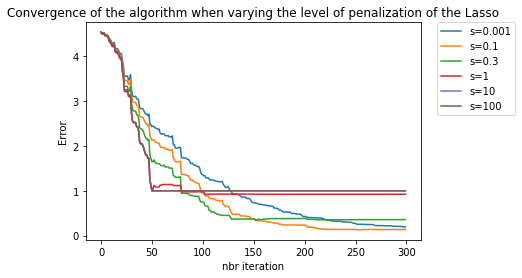

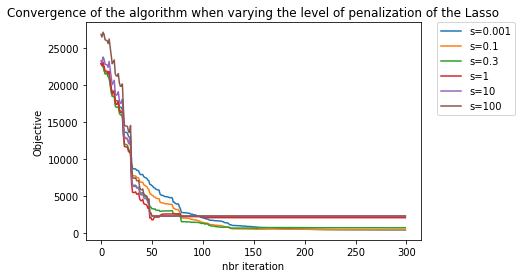

In [13]:
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)

for i in range (len(s)):
    ax1.plot(list_errors[i][:300],label = 's='+str(s[i]))

ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm when varying the level of penalization of the Lasso")
plt.show()


fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)

for i in range (len(s)):
    ax2.plot(list_objectives[i][:300],label = 's='+str(s[i]))

ax2.set_xlabel("nbr iteration")
ax2.set_ylabel("Objective")
#ax2.set_yscale("log")
ax2.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm when varying the level of penalization of the Lasso")
plt.show()

### Comment :

For the lasso penalization, the penalization parameter "s" controls the tradeoff between fit and complexity: both the coefficient values and the speed of convergence are impacted by this parameter. We observe that the speed of convergence is faster when the strength of penalization is large. However, as the penalization increases, the error rate is higher. It is due to the threshold effect of the lasso penalization (see Part 1 of TP1, "Visualization"): when s is large, almost all the coefficients are equal to zero. We had the same observation with the FISTA and ISTA algorithms. 

For the indicator function, varrying s when using the indicator function does not have any effect whatsoever on the result, since s does not intervene in any step of the search for the minimum.


Given this result, it could be interesting to compare the convergence of the algorithm with :
- the indicator function, and,
- the lasso penalization with a larger penalization parameter than 0.01 (default value in TP1).

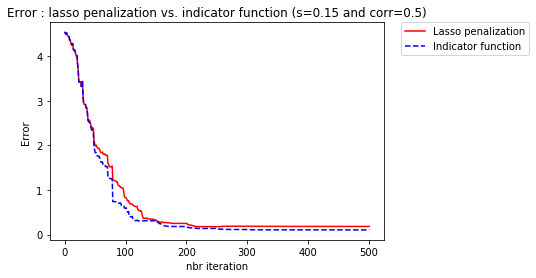

In [14]:
s= 0.15
x,objectives,errors=cd_linreg(x0,A,b,lasso,prox_lasso,s=s,n_iter=500,x_true=coefs,verbose=False)
x2,objectives2,errors2=cd_linreg(x0,A,b,Indic,prox_indic_Coord,s=s,n_iter=500,x_true=coefs,verbose=False)

fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)
ax1.plot(errors,"r",label = "Lasso penalization")
ax1.plot(errors2,"b--",label = "Indicator function") 
ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Error : lasso penalization vs. indicator function (s="+ str(s)+" and corr=0.5)")
plt.show()



### Comment :
We observe that the performance of the algorithms are closer when we use s=0.15 (instead of s=0.01). Hence, the impact of the penalization function on the algorithm performance depends on the parameter values ("s" or "corr").

# iii) Effect of the correlation of the features

### Data

In [15]:
s=0.01
x0=np.random.randn(n_features)
corr=[0.1*i for i in range(10)]

## Lasso penalization

In [16]:
list_errors=[]
list_objectives=[]

for var in corr:
    A,b=simu_linreg(coefs,corr=var)
    x,objectives,errors=cd_linreg(x0,A,b,lasso,prox_lasso,s,n_iter=500,x_true=coefs,verbose=False)
    list_errors.append(errors)
    list_objectives.append(objectives)

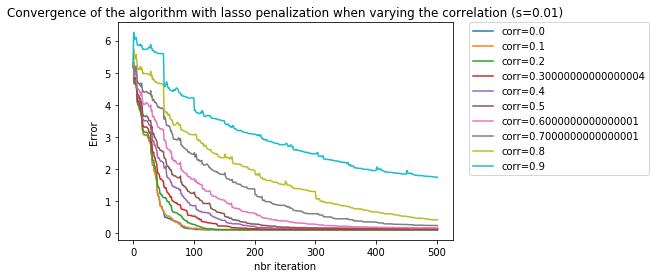

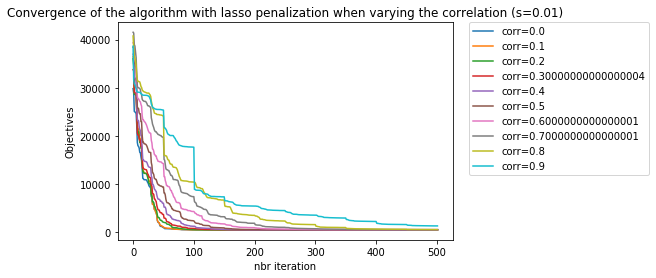

In [17]:

fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)

for i in range (len(corr)):
    ax1.plot(list_errors[i],label = 'corr='+str(corr[i]))
    
ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with lasso penalization when varying the correlation (s=0.01)")
plt.show()


fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)

for i in range (len(corr)):
    ax2.plot(list_objectives[i],label = 'corr='+str(corr[i]))
    
ax2.set_xlabel("nbr iteration")
ax2.set_ylabel("Objectives")
#ax2.set_yscale("log")
ax2.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with lasso penalization when varying the correlation (s=0.01)")
plt.show()

## Indicator function

In [18]:
list_errors=[]
list_objectives=[]


for var in corr:
    A,b=simu_linreg(coefs,corr=var)
    x,objectives,errors=cd_linreg(x0,A,b,Indic,prox_indic_Coord,s,n_iter=500,x_true=coefs,verbose=False)
    list_errors.append(errors)
    list_objectives.append(objectives)

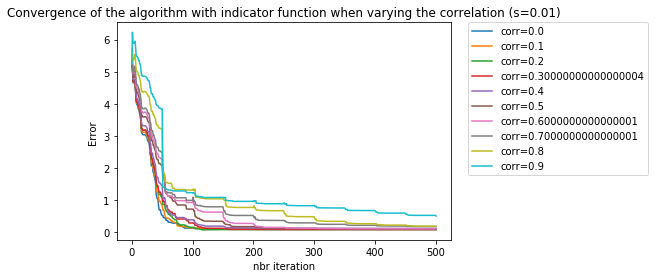

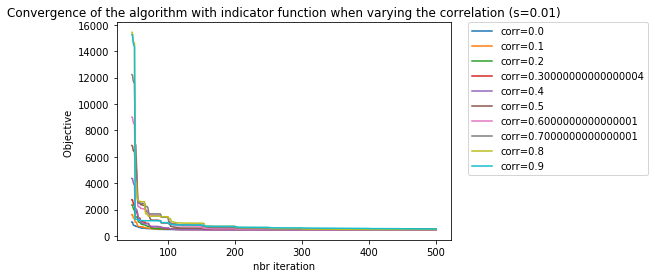

In [19]:
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)

for i in range(len(corr)):
    ax1.plot(list_errors[i],label = 'corr='+str(corr[i]))
    
ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with indicator function when varying the correlation (s=0.01)")
plt.show()

fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)

for i in range(len(corr)):
    ax2.plot(list_objectives[i],label = 'corr='+str(corr[i]))
    
ax2.set_xlabel("nbr iteration")
ax2.set_ylabel("Objective ")
#x2.set_yscale("log")
ax2.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with indicator function when varying the correlation (s=0.01)")
plt.show()

### Comment :


For both penalization functions, we can see that as the features correlation increases (i.e. the conditionning gets worse), the algorithms' speed of convergence decreases. 


Besides, high correlation of features seems to be more problematic for the lasso penalization. The error is larger with the lasso penalization since it usually selects one variable to represente a group of higly correlated features. 

## iv) Simunasteously effect of the level of penalization and correlation 

We have seen that a large correlation of features leads to a very slow convergence whereas a large penalization parameter increases the rate of convergence. Does an increase in the parameter of penalization "s" compensate a high correlation of features ?

We will pick up a value of "s" larger than the default value (s=0.01) but not too large (in order to avoid bias). Taking s = 0.3 seems to be a good compromise.

In [20]:
list_errors=[]
list_objectives=[]

for var in corr:
    A,b=simu_linreg(coefs,corr=var)
    x,objectives,errors=cd_linreg(x0,A,b,lasso,prox_lasso,s=0.3,n_iter=500,x_true=coefs,verbose=False)
    list_errors.append(errors)
    list_objectives.append(objectives)

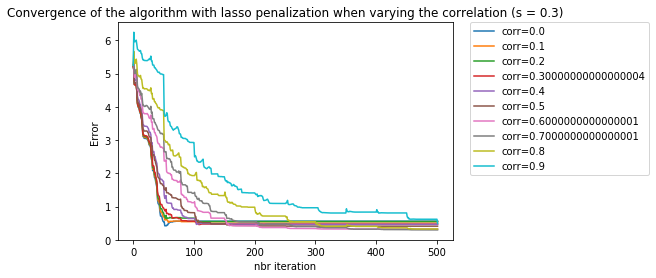

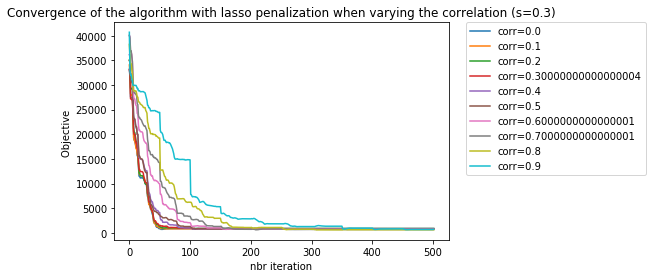

In [21]:
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1) 

for i in range(len(corr)):
    ax1.plot(list_errors[i],label = 'corr='+str(corr[i]))
    
ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with lasso penalization when varying the correlation (s = 0.3)")
plt.show()

fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)

for i in range(len(corr)):
    ax2.plot(list_objectives[i],label = 'corr='+str(corr[i]))
    
ax2.set_xlabel("nbr iteration")
ax2.set_ylabel("Objective ")
#x2.set_yscale("log")
ax2.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with lasso penalization when varying the correlation (s=0.3)")
plt.show()

### Comment :
For lasso penalization, a small increase in the level of penalization ("s" around 0.3 for example) can reduce the bad effect of a high correlation of the features. In this way, the penalization parameter can be a tool for compensating a high degree of correlation.


## v) Effect of the number of samples

A bad conditioning can also be related to an imbalance between the number of samples and the number of features (i.e., too many samples with too few features, or too few samples with too many features). 

In the following, we will set the number of features at 50 and we will vary the number of samples. 

## Lasso penalization

In [22]:
n=[25,50,100,300,500]
s=0.01

In [23]:
list_errors=[]
list_objectives=[]

for i in n:
    A,b=simu_linreg(coefs,corr=0.5,n_samples=i)
    x,objectives,errors=cd_linreg(x0,A,b,lasso,prox_lasso,s=s,n_iter=500,x_true=coefs,verbose=False)
    list_errors.append(errors)
    list_objectives.append(objectives)

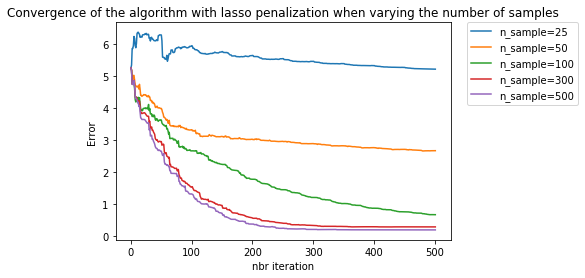

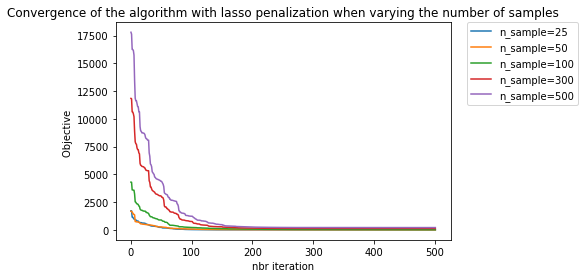

In [24]:
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1) 

for i in range (len(n)):
    ax1.plot(list_errors[i],label = 'n_sample='+str(n[i]))
    
ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with lasso penalization when varying the number of samples")
plt.show()

fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)

for i in range(len(n)):
    ax2.plot(list_objectives[i],label = 'n_sample='+str(n[i]))
    
ax2.set_xlabel("nbr iteration")
ax2.set_ylabel("Objective ")
#x2.set_yscale("log")
ax2.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with lasso penalization when varying the number of samples")
plt.show()

## Indicator function

In [25]:
list_errors=[]
list_objectives=[]

for i in n:
    A,b=simu_linreg(coefs,corr=0.5,n_samples=i)
    x,objectives,errors=cd_linreg(x0,A,b,Indic,prox_indic_Coord,s,n_iter=500,x_true=coefs,verbose=False)
    list_errors.append(errors)
    list_objectives.append(objectives)

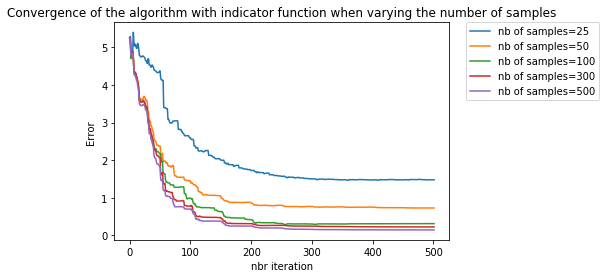

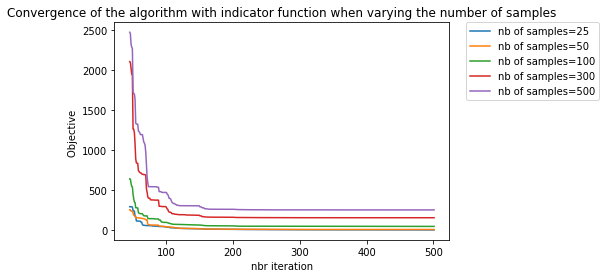

In [26]:
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)
for i in range (len(n)):
    ax1.plot(list_errors[i],label = 'nb of samples='+str(n[i]))    
ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with indicator function when varying the number of samples")
plt.show()

fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)
for i in range (len(n)):
    ax2.plot(list_objectives[i],label = 'nb of samples='+str(n[i]))    
ax2.set_xlabel("nbr iteration")
ax2.set_ylabel("Objective ")
#ax2.set_yscale("log")
ax2.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.title("Convergence of the algorithm with indicator function when varying the number of samples")
plt.show()

### Comments :

For both penalization functions, the speed of the convergence is highly affected by the number of samples.
This proves that having a large dataset is necessary for the coordinate descent to work properly. In addition, the algorithm is more impacted by a bad conditioning when using lasso penalization. 


When the number of samples is smaller than the number of features, both algorithms reach the minimum of the objective function fast, but the error remains very large. For the lasso penalization, when n_samples=25, we can clearly see that the algorithm does not converge (even after 500 iterations). When the number of covariates (50 in our case) is greater than the number of samples (say "N"), lasso selects only N covariates. Therefore the error is larger(information loss). 



# Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.


A bad conditioning arises when:

- s is too large for lasso penalization (large error) or too small (slow convergence),
- there is a high correlation of features (slow convergence),
- there is an imbalance between the number of samples and the number of features (too few samples given a number of covariates).

## Proximal Gradient Descent : Ista algorithm

In [27]:
def ista(x0, g, prox_g, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    #Definition of the loss function for linear regression
    def f(x):
        """Least-squares loss"""
        n = b.size
        return (np.linalg.norm(b - A.dot(x), ord=2) ** 2) / (2 * n)

    #Definition of the gradient of the loss function for linear regression
    def grad_f(x):
        """Least-squares gradient"""
        n = b.size
        return - A.T.dot((b - A.dot(x))) / n

    
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    
    #Step
    step=1/(np.linalg.norm(A.T.dot(A), ord=2) / n_samples)

    # estimation error history
    errors = []
    
    # objective history
    objectives = []
    
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter):
        x_new = prox_g(x - step * grad_f(x), s * step)
        x = x_new.copy()
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

## Overview of the performance of the ista and coordinate gradient descent algorithms
### Data

The cost of coordinate descent is much smaller than the cost of gradient descent:
$$
C_{Coordiante\ Descent}=\frac{C_{Gradient\ Descent}}{n_{features}}
$$
Consequently, we have to choose an adapted method to compare both methods. 
We can change the scale for the coordinate descent considering that each step of the coordinate descent is equivalent to n_features steps for the gradient descent, in terms of cost. 



In [28]:
A,b=simu_linreg(coefs, corr=0.5)
n_samples, n_features = A.shape
x0=np.random.randn(n_features)
s=0.01
n_iter=500
scale_cd=[n_features*i for i in range (n_iter)]

In [29]:
A,b=simu_linreg(coefs,corr=0.1)

x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,
                                       lasso,prox_lasso,
                                       s=s,n_iter=n_iter*n_features,
                                       x_true=coefs,
                                       verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, prox_g=prox_lasso, 
                                  s=s, n_iter=n_iter, 
                                  x_true=coefs,
                                  verbose=False)

scaled_errors_cd=[errors_cd[i] for i in scale_cd]
scaled_objectives_cd=[objectives_cd[i] for i in scale_cd]

In [30]:
x_cd1,objectives_cd1,errors_cd1=cd_linreg(x0,A,b,
                                       Indic,prox_indic_Coord,
                                       s=s,n_iter=n_iter*n_features,
                                       x_true=coefs,
                                       verbose=False)
x_gd1,objectives_gd1,errors_gd1=ista(x0=x0,g=Indic, prox_g=prox_Indic, 
                                  s=s, n_iter=n_iter, 
                                  x_true=coefs,
                                  verbose=False)

scaled_errors_cd1=[errors_cd1[i] for i in scale_cd]
scaled_objectives_cd1=[objectives_cd1[i] for i in scale_cd]

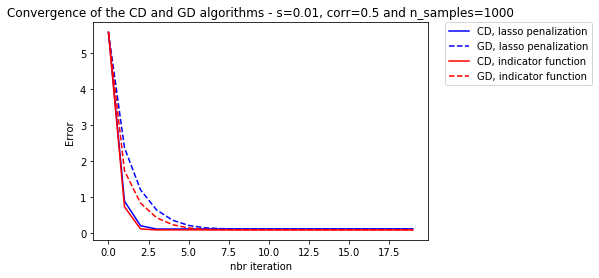

In [31]:
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(scaled_errors_cd[:20],"b",label = "CD, lasso penalization")
ax1.plot(errors_gd[:20],"b--",label = "GD, lasso penalization")

ax1.plot(scaled_errors_cd1[:20],"r",label = "CD, indicator function")
ax1.plot(errors_gd1[:20],"r--",label = "GD, indicator function")

ax1.set_xlabel("nbr iteration")
ax1.set_ylabel("Error ")
#ax.set_yscale("log")
plt.title("Convergence of the CD and GD algorithms - s=0.01, corr=0.5 and n_samples=1000")
ax1.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()


The figure shows clearly that the difference between both coordinate descent graphs is not that obvious compared to the difference between the two gradient descent graphs (dotted lines). 

Consequently, coordinate descent algorithm is less affected by the penalization function than the gradient descent algorithm.

Let us now consider:
- effect of  the number of samples:
- effect of the level of penalization
- effect of the correlation of the features



# Effect of the number of samples

In [32]:
n=[100, 5000]
s= 0.01
n_iter=500
scale_cd=[n_features*i for i in range (n_iter)]

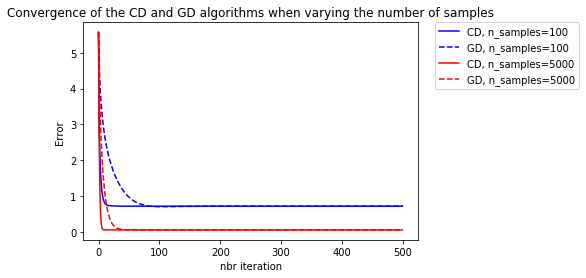

In [33]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

# bad conditioning
A,b=simu_linreg(coefs,corr=0.5,n_samples=n[0])
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,
                                       prox_lasso,s=s,
                                       n_iter=n_iter*n_features,
                                       x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, prox_g=prox_lasso, 
                                       s=s, n_iter=n_iter, 
                                       x_true=coefs,verbose=False)
scaled_errors_cd=[errors_cd[i] for i in scale_cd]
ax.plot(scaled_errors_cd,"b",label = "CD, n_samples="+str(n[0]))
ax.plot(errors_gd,"b--",label = "GD, n_samples="+str(n[0]))

# good conditioning
A,b=simu_linreg(coefs,corr=0.5,n_samples=n[1])
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,
                                       prox_lasso,s=s,
                                       n_iter=n_iter*n_features,
                                       x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, prox_g=prox_lasso, 
                                       s=s, n_iter=n_iter, 
                                       x_true=coefs,verbose=False)
scaled_errors_cd=[errors_cd[i] for i in scale_cd]
ax.plot(scaled_errors_cd,"r",label = "CD, n_samples="+str(n[1]))
ax.plot(errors_gd,"r--",label = "GD, n_samples="+str(n[1]))

ax.set_xlabel("nbr iteration")
ax.set_ylabel("Error ")
plt.title("Convergence of the CD and GD algorithms when varying the number of samples")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()

when increasing the number of samples, we can clearly see that gradient descent (dotted lines) is much more affected.

## Correlation of the features

In [34]:
corr=[0.2, 0.7]
s= 0.01
n_iter=500
scale_cd=[n_features*i for i in range (n_iter)]

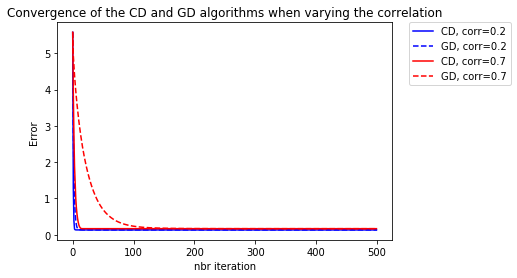

In [35]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

A,b=simu_linreg(coefs,corr=corr[0])
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,prox_lasso,s=s,n_iter=n_iter*n_features,x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter, x_true=coefs,verbose=False)

scaled_errors_cd=[errors_cd[i] for i in scale_cd]

ax.plot(scaled_errors_cd,"b",label = "CD, corr="+str(corr[0]))
ax.plot(errors_gd,"b--",label = "GD, corr="+str(corr[0]))


A,b=simu_linreg(coefs,corr=corr[1])
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,prox_lasso,s=s,n_iter=n_iter*n_features,x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, prox_g=prox_lasso, s=s, n_iter=n_iter, x_true=coefs,verbose=False)

scaled_errors_cd=[errors_cd[i] for i in scale_cd]

ax.plot(scaled_errors_cd,"r",label = "CD, corr="+str(corr[1]))
ax.plot(errors_gd,"r--",label = "GD, corr="+str(corr[1]))

ax.set_xlabel("nbr iteration")
ax.set_ylabel("Error ")
plt.title("Convergence of the CD and GD algorithms when varying the correlation")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)

plt.show()

The conclusion of the previous graphs still holds for the variation of the correlation of the features. These graphs shows that gradient descent are much more affected by bad conditioning as we can see when correlation=0.7 for the gradient descent (slow convergence).

## Level of penalization 

In [39]:
corr=0.5
s=[0.001,0.01, 0.4]
n_iter=500
scale_cd=[n_features*i for i in range (n_iter)]

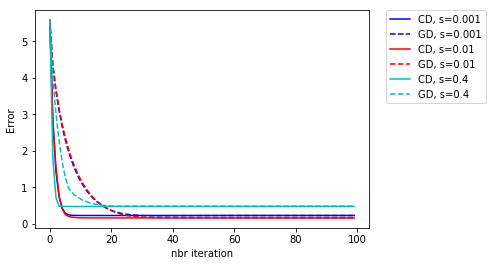

In [41]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

A,b=simu_linreg(coefs,corr=corr)
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,
                                       prox_lasso,s=s[0],
                                       n_iter=n_iter*n_features,
                                       x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, prox_g=prox_lasso, 
                                       s=s[0], n_iter=n_iter, 
                                       x_true=coefs,verbose=False)

scaled_errors_cd=[errors_cd[i] for i in scale_cd]

ax.plot(scaled_errors_cd[:100],"b",label = "CD, s="+str(s[0]))
ax.plot(errors_gd[:100],"b--",label = "GD, s="+str(s[0]))


A,b=simu_linreg(coefs,corr=corr)
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,
                                       prox_lasso,s=s[1],
                                       n_iter=n_iter*n_features,
                                       x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, 
                                       prox_g=prox_lasso, 
                                       s=s[1], n_iter=n_iter,  
                                       x_true=coefs,verbose=False)

scaled_errors_cd=[errors_cd[i] for i in scale_cd]

ax.plot(scaled_errors_cd[:100],"r",label = "CD, s="+str(s[1]))
ax.plot(errors_gd[:100],"r--",label = "GD, s="+str(s[1]))



A,b=simu_linreg(coefs,corr=corr)
x_cd,objectives_cd,errors_cd=cd_linreg(x0,A,b,lasso,
                                       prox_lasso,s=s[2],
                                       n_iter=n_iter*n_features,
                                       x_true=coefs,verbose=False)
x_gd,objectives_gd,errors_gd=ista(x0=x0,g=lasso, 
                                       prox_g=prox_lasso, 
                                       s=s[2], n_iter=n_iter,  
                                       x_true=coefs,verbose=False)

scaled_errors_cd=[errors_cd[i] for i in scale_cd]

ax.plot(scaled_errors_cd[:100],"c",label = "CD, s="+str(s[2]))
ax.plot(errors_gd[:100],"c--",label = "GD, s="+str(s[2]))




ax.set_xlabel("nbr iteration")
ax.set_ylabel("Error ")

ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)

plt.show()

The coordinate descent algorithm does not seem less affected by a bad conditioning of "s" than the gradient descent algorithm.

#### Conclusion : 

To conclude, the coordinate descent algorithm is less impacted by a bad conditioning concerning the "structure" of the data (number of samples, correlation of the features).